In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import metrics as sk_metrics
from sklearn.metrics import classification_report

import data
import uncertainty_estimation as ue
from main_bayesian import getModel
import config_bayesian as cfg
import utils
import torch
import metrics
from torch.nn import functional as F
import config_bayesian as cfg
import pandas as pd
import seaborn as sns


/home/marisa/anaconda3/envs/pytorch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())


False


In [3]:
source = cfg.source # 0: work computer, 1: laptop. NOTE: also change in data.py
print(source)

0


In [4]:
trainset, testset, inputs, num_classes = data.getDataset('POCUS')
train_loader, valid_loader, test_loader = data.getDataloader(trainset, testset, cfg.valid_size, batch_size=1, num_workers=cfg.num_workers)
train_combo, test_combo, inputs, num_classes = data.getDataset('OOD_combo')
_, _, combo_loader = data.getDataloader(train_combo, test_combo, cfg.valid_size, batch_size=1, num_workers=cfg.num_workers)
train_cca, test_cca, inputs, num_classes = data.getDataset('OOD_CCA_US')
_, _, cca_loader = data.getDataloader(train_cca, test_cca, cfg.valid_size, batch_size=1, num_workers=cfg.num_workers)
train_mnist, test_mnist, inputs, num_classes = data.getDataset('MNIST')
_, _, mnist_loader = data.getDataloader(train_mnist, test_mnist, cfg.valid_size, batch_size=1, num_workers=cfg.num_workers)

ckpt_name = 'model_custom_bbb_relu_2023-10-30_1OK53'
net_type = 'custom' 

loc_pc = '/home/marisa/Documents'
loc_lap = 'C:/Users/maris/Documents/Thesis'
locs = [loc_pc, loc_lap]
loc = locs[source]

# Load model
ckpt = f'{loc}/PyTorch-BayesianCNN/checkpoints/POCUS/bayesian/{ckpt_name}.pt'
layer_type = cfg.layer_type
activation_type = cfg.activation_type

net = getModel(net_type, inputs, num_classes, priors=None, layer_type=layer_type, activation_type=activation_type)
net = net.to(device)
net.load_state_dict(torch.load(ckpt, map_location=device)["model_state_dict"])
net.train() # should this be train or eval?

found data in  /home/marisa/Documents/Thesis/Data/POCUS_and_US/Train/  :  1236
found data in  /home/marisa/Documents/Thesis/Data/DATA_FOR_ISBI/GE_Test/  :  531
found data in  /home/marisa/Documents/Thesis/Data/DATA_FOR_ISBI/Combo/  :  531
found data in  /home/marisa/Documents/Thesis/Data/DATA_FOR_ISBI/Combo/  :  531
length of OOD set:  531
found data in  /home/marisa/Documents/Thesis/Data/DATA_FOR_ISBI/CCA_US/OOD/  :  84
length of train set:  84
found data in  /home/marisa/Documents/Thesis/Data/DATA_FOR_ISBI/CCA_US/OOD/  :  84
length of MNIST test set:  10000


BBBCustom(
  (conv1): BBBConv2d()
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): BBBConv2d()
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): BBBConv2d()
  (act3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): BBBConv2d()
  (act4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): BBBConv2d()
  (act5): ReLU()
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): FlattenLayer()
  (fc1): BBBLinear()
  (act6): ReLU()
  (fc2): BBBLinear()
)

In [5]:
def evaluate_uncertainties(net, testset):

    n_samples = len(testset)
    
    uncertainties = []

    for idx in range(n_samples):
        sample, truth = testset[idx]
        sample = sample.to(device)

        pred, epi_norm, ale_norm = ue.get_uncertainty_per_image(net, sample, T=32, normalized=True)
        pred, epi_soft, ale_soft = ue.get_uncertainty_per_image(net, sample, T=32, normalized=False)

        pred = int(np.argmax(pred))
        uncertainties.append([epi_norm[0], 
                              epi_norm[1],
                              epi_norm[2],
                              ale_norm[0],
                              ale_norm[1],
                              ale_norm[2], 
                              epi_soft[0], 
                              epi_soft[1], 
                              epi_soft[2], 
                              ale_soft[0], 
                              ale_soft[1], 
                              ale_soft[2], 
                              epi_norm[pred],
                              ale_norm[pred],
                              epi_soft[pred],
                              ale_soft[pred],
                              truth==pred, 
                              truth, 
                              pred
                              ])


    return uncertainties

In [6]:
uncertainties_GE_test = evaluate_uncertainties(net, testset)
df_GE_test = pd.DataFrame(uncertainties_GE_test, columns=['epi_norm_0', 'epi_norm_1', 'epi_norm_2', 'ale_norm_0', 'ale_norm_1', 'ale_norm_2', 'epi_soft_0', 'epi_soft_1', 'epi_soft_2', 'ale_soft_0', 'ale_soft_1', 'ale_soft_2', 'epi_norm_pred', 'ale_norm_pred', 'epi_soft_pred', 'ale_soft_pred', 'correct', 'truth', 'pred'])

In [7]:
uncertainties_OOD_combo = evaluate_uncertainties(net, test_combo)
df_OOD_combo = pd.DataFrame(uncertainties_OOD_combo, columns=['epi_norm_0', 'epi_norm_1', 'epi_norm_2', 'ale_norm_0', 'ale_norm_1', 'ale_norm_2', 'epi_soft_0', 'epi_soft_1', 'epi_soft_2', 'ale_soft_0', 'ale_soft_1', 'ale_soft_2', 'epi_norm_pred', 'ale_norm_pred', 'epi_soft_pred', 'ale_soft_pred', 'correct', 'truth', 'pred'])

In [8]:
uncertainties_OOD_cca = evaluate_uncertainties(net, test_cca)
df_OOD_cca = pd.DataFrame(uncertainties_OOD_cca, columns=['epi_norm_0', 'epi_norm_1', 'epi_norm_2', 'ale_norm_0', 'ale_norm_1', 'ale_norm_2', 'epi_soft_0', 'epi_soft_1', 'epi_soft_2', 'ale_soft_0', 'ale_soft_1', 'ale_soft_2', 'epi_norm_pred', 'ale_norm_pred', 'epi_soft_pred', 'ale_soft_pred', 'correct', 'truth', 'pred'])

In [9]:
uncertainties_OOD_mnist = evaluate_uncertainties(net, test_mnist)
df_OOD_mnist = pd.DataFrame(uncertainties_OOD_mnist, columns=['epi_norm_0', 'epi_norm_1', 'epi_norm_2', 'ale_norm_0', 'ale_norm_1', 'ale_norm_2', 'epi_soft_0', 'epi_soft_1', 'epi_soft_2', 'ale_soft_0', 'ale_soft_1', 'ale_soft_2', 'epi_norm_pred', 'ale_norm_pred', 'epi_soft_pred', 'ale_soft_pred', 'correct', 'truth', 'pred'])

In [10]:
df_GE_test

,epi_norm_0,epi_norm_1,epi_norm_2,ale_norm_0,ale_norm_1,ale_norm_2,epi_soft_0,epi_soft_1,epi_soft_2,ale_soft_0,ale_soft_1,ale_soft_2,epi_norm_pred,ale_norm_pred,epi_soft_pred,ale_soft_pred,correct,truth,pred
0,7.993606e-15,2.220446e-16,8.881784e-16,0.229301,0.141742,0.249266,2.220446e-14,3.552714e-15,7.993606e-15,0.250000,0.142271,0.220633,7.993606e-15,0.229301,2.220446e-14,0.250000,False,1,0
1,1.421085e-14,3.469447e-16,7.993606e-15,0.219495,0.056670,0.194792,3.552714e-15,4.996004e-16,1.421085e-14,0.202749,0.057742,0.225712,7.993606e-15,0.194792,1.421085e-14,0.225712,False,1,2
2,0.000000e+00,2.220446e-16,1.421085e-14,0.201683,0.163963,0.249828,3.552714e-15,7.993606e-15,7.993606e-15,0.249846,0.203756,0.175712,0.000000e+00,0.201683,3.552714e-15,0.249846,False,1,0
3,7.993606e-15,1.421085e-14,7.993606e-15,0.172309,0.239267,0.236154,5.551115e-17,2.220446e-16,1.421085e-14,0.040928,0.055280,0.091186,7.993606e-15,0.236154,1.421085e-14,0.091186,False,1,2
4,8.881784e-16,2.220446e-14,3.552714e-15,0.201645,0.242901,0.211644,3.552714e-15,5.551115e-15,7.993606e-15,0.242825,0.153168,0.239160,8.881784e-16,0.201645,3.552714e-15,0.242825,False,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,8.881784e-16,7.993606e-15,7.993606e-15,0.190895,0.188641,0.249916,5.551115e-15,3.552714e-15,0.000000e+00,0.161021,0.235952,0.243081,7.993606e-15,0.249916,0.000000e+00,0.243081,True,2,2
527,1.998401e-15,3.552714e-15,2.220446e-14,0.131926,0.245143,0.242485,1.387779e-17,8.881784e-16,1.421085e-14,0.020215,0.152682,0.165135,2.220446e-14,0.242485,1.421085e-14,0.165135,True,2,2
528,7.993606e-15,7.993606e-15,7.993606e-15,0.184365,0.236027,0.234224,2.220446e-16,1.088019e-14,3.552714e-15,0.137389,0.175285,0.238137,7.993606e-15,0.234224,3.552714e-15,0.238137,True,2,2
529,0.000000e+00,1.421085e-14,1.421085e-14,0.187371,0.243641,0.221099,8.881784e-16,5.684342e-14,0.000000e+00,0.080068,0.244237,0.223207,1.421085e-14,0.243641,5.684342e-14,0.244237,False,2,1


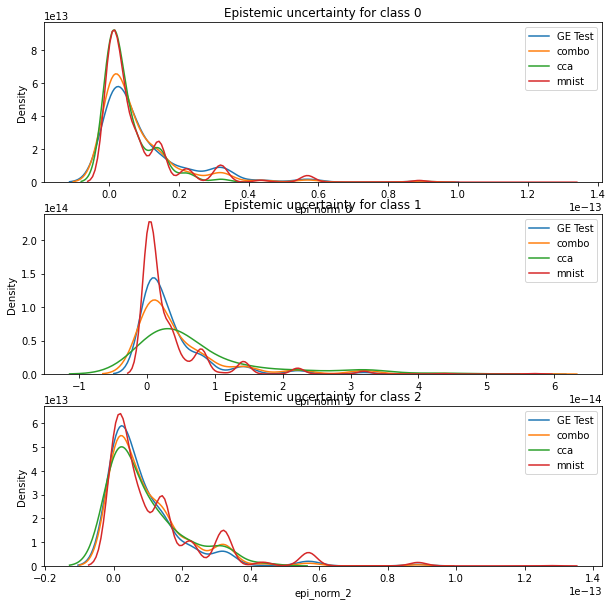

In [11]:
fig = plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)    
sns.kdeplot(df_GE_test['epi_norm_0'], label='GE Test')
sns.kdeplot(df_OOD_combo['epi_norm_0'], label='combo')
sns.kdeplot(df_OOD_cca['epi_norm_0'], label='cca')
sns.kdeplot(df_OOD_mnist['epi_norm_0'], label='mnist')
plt.legend()
plt.title('Epistemic uncertainty for class 0')

plt.subplot(3, 1, 2)
sns.kdeplot(df_GE_test['epi_norm_1'], label='GE Test')
sns.kdeplot(df_OOD_combo['epi_norm_1'], label='combo')
sns.kdeplot(df_OOD_cca['epi_norm_1'], label='cca')
sns.kdeplot(df_OOD_mnist['epi_norm_1'], label='mnist')
plt.legend()
plt.title('Epistemic uncertainty for class 1')

plt.subplot(3, 1, 3)
sns.kdeplot(df_GE_test['epi_norm_2'], label='GE Test')
sns.kdeplot(df_OOD_combo['epi_norm_2'], label='combo')
sns.kdeplot(df_OOD_cca['epi_norm_2'], label='cca')
sns.kdeplot(df_OOD_mnist['epi_norm_2'], label='mnist')
plt.legend()
plt.title('Epistemic uncertainty for class 2')

plt.show()

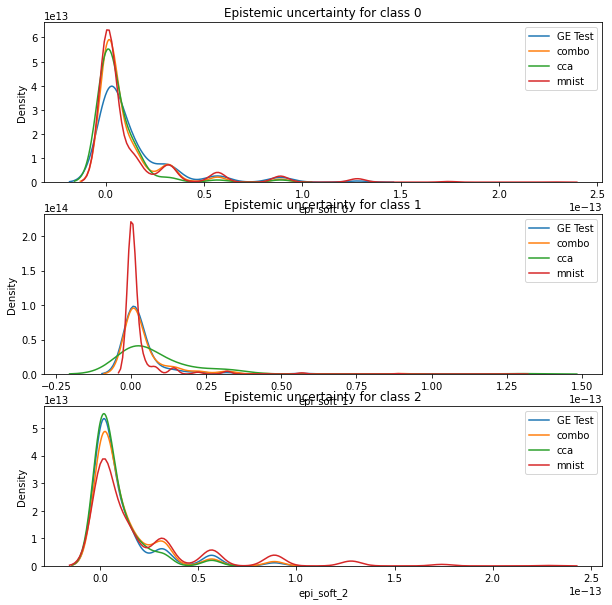

In [12]:
fig = plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)    
sns.kdeplot(df_GE_test['epi_soft_0'], label='GE Test')
sns.kdeplot(df_OOD_combo['epi_soft_0'], label='combo')
sns.kdeplot(df_OOD_cca['epi_soft_0'], label='cca')
sns.kdeplot(df_OOD_mnist['epi_soft_0'], label='mnist')
plt.legend()
plt.title('Epistemic uncertainty for class 0')

plt.subplot(3, 1, 2)
sns.kdeplot(df_GE_test['epi_soft_1'], label='GE Test')
sns.kdeplot(df_OOD_combo['epi_soft_1'], label='combo')
sns.kdeplot(df_OOD_cca['epi_soft_1'], label='cca')
sns.kdeplot(df_OOD_mnist['epi_soft_1'], label='mnist')
plt.legend()
plt.title('Epistemic uncertainty for class 1')

plt.subplot(3, 1, 3)
sns.kdeplot(df_GE_test['epi_soft_2'], label='GE Test')
sns.kdeplot(df_OOD_combo['epi_soft_2'], label='combo')
sns.kdeplot(df_OOD_cca['epi_soft_2'], label='cca')
sns.kdeplot(df_OOD_mnist['epi_soft_2'], label='mnist')
plt.legend()
plt.title('Epistemic uncertainty for class 2')

plt.show()

Text(0.5, 1.0, 'Epistemic uncertainty for class 0')

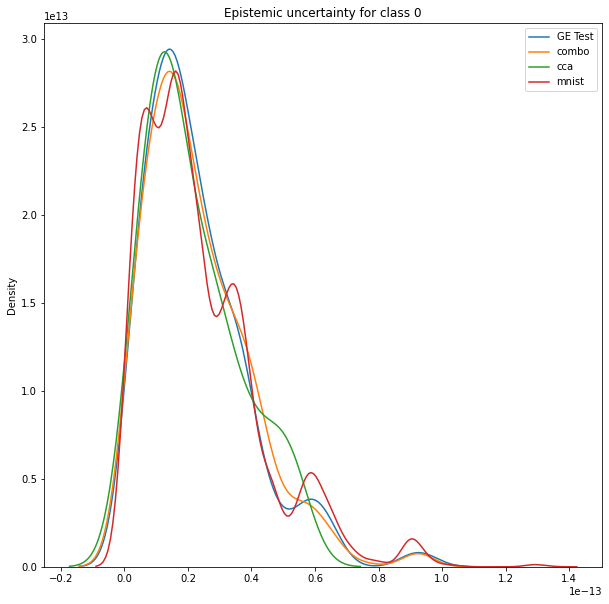

In [13]:
fig = plt.figure(figsize=(10, 10))
  
sns.kdeplot(df_GE_test.epi_norm_0+df_GE_test.epi_norm_1+df_GE_test.epi_norm_2, label='GE Test')
sns.kdeplot(df_OOD_combo.epi_norm_0+df_OOD_combo.epi_norm_1+df_OOD_combo.epi_norm_2, label='combo')
sns.kdeplot(df_OOD_cca.epi_norm_0+df_OOD_cca.epi_norm_1+df_OOD_cca.epi_norm_2, label='cca')
sns.kdeplot(df_OOD_mnist.epi_norm_0+df_OOD_mnist.epi_norm_1+df_OOD_mnist.epi_norm_2, label='mnist')
plt.legend()
plt.title('Epistemic uncertainty for class 0')

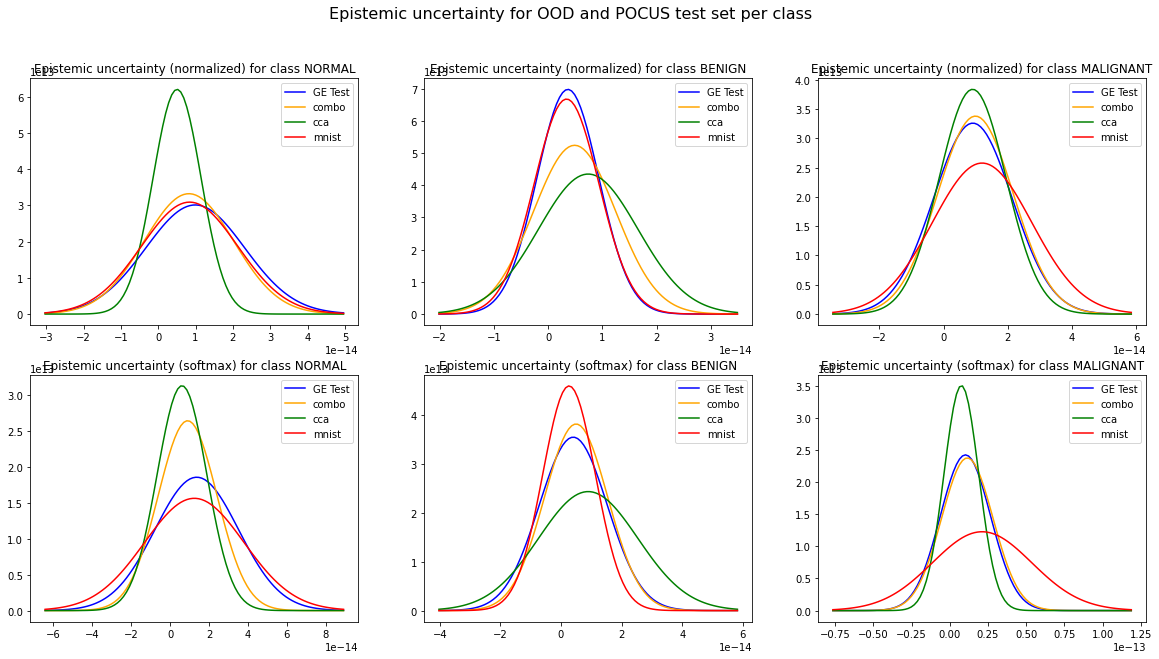

In [14]:
from scipy.stats import norm
import scipy.stats as stats
fig = plt.figure(figsize=(20,10))
rows, cols = 2,3

columns = ['epi_norm_0', 'epi_norm_1', 'epi_norm_2', 'epi_soft_0', 'epi_soft_1', 'epi_soft_2']
titles = ['Epistemic uncertainty (normalized) for class NORMAL', 'Epistemic uncertainty (normalized) for class BENIGN', 'Epistemic uncertainty (normalized) for class MALIGNANT','Epistemic uncertainty (softmax) for class NORMAL','Epistemic uncertainty (softmax) for class BENIGN','Epistemic uncertainty (softmax) for class MALIGNANT']

for i, col in enumerate(columns):
    # plot normal distribution with mean and std values from the column 
    fig.add_subplot(rows, cols, columns.index(col)+1)

    mu_POCUS = np.mean(df_GE_test[col])
    sigma_POCUS = np.std(df_GE_test[col])
    mu_OOD_combo = np.mean(df_OOD_combo[col])
    sigma_OOD_combo = np.std(df_OOD_combo[col])
    mu_OOD_cca = np.mean(df_OOD_cca[col])
    sigma_OOD_cca = np.std(df_OOD_cca[col])
    mu_OOD_mnist = np.mean(df_OOD_mnist[col])
    sigma_OOD_mnist = np.std(df_OOD_mnist[col])

    x_axis = np.linspace(min(mu_POCUS-3*sigma_POCUS, mu_OOD_combo-3*sigma_OOD_combo, mu_OOD_cca-3*sigma_OOD_cca, mu_OOD_mnist-3*sigma_OOD_mnist), max(mu_POCUS+3*sigma_POCUS, mu_OOD_combo+3*sigma_OOD_combo, mu_OOD_cca+3*sigma_OOD_cca, mu_OOD_mnist+3*sigma_OOD_mnist), 100)


    plt.plot(x_axis, stats.norm.pdf(x_axis,mu_POCUS, sigma_POCUS), label='GE Test', color='blue')
    plt.plot(x_axis, stats.norm.pdf(x_axis,mu_OOD_combo, sigma_OOD_combo), label='combo', color='orange')
    plt.plot(x_axis, stats.norm.pdf(x_axis,mu_OOD_cca, sigma_OOD_cca), label='cca', color='green')
    plt.plot(x_axis, stats.norm.pdf(x_axis,mu_OOD_mnist, sigma_OOD_mnist), label='mnist', color='red')
    plt.legend()
    plt.title(titles[i])

fig.suptitle('Epistemic uncertainty for OOD and POCUS test set per class', fontsize=16) 
plt.show()